In [222]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import matplotlib.ticker as ticker
import helper_fcns as hlp
import autoreload
import os
from scipy.stats import norm, wilcoxon
matplotlib.style.use('plt_style.mplstyle')
%matplotlib inline

In [223]:
autoreload.reload(hlp);

Set the parameters for the data you want

In [270]:
dataDir = 'data/CSF/';
saveDir = dataDir + 'results/';
subj = 1;
disp = 1;
conv_sf = lambda s: 1e-2*float(s); # 1e-2 becuase I zero pad the string...

sfList = [];
dataMat = [];

Get the data

In [277]:
dataList = os.listdir(dataDir);

for entry in dataList:
    if entry.startswith('csf') and entry.endswith('txt'):
        # find subject, dispersion, sf
        disp_curr = int(entry[entry.find('_d')+2]); # + 1 for zero index, +1 for getting the following integer
        subj_start = entry.find('_s')+ 2;
        subj_curr = int(entry[subj_start:subj_start+2])
        sf_start = entry.find('_sf') + 3; # add 3 to skip the _sf
        sf_curr = np.round(conv_sf(entry[sf_start : sf_start + 4]), 2) # 4 characters long
        
        if disp == disp_curr and subj == subj_curr:
            curr_data = np.loadtxt(dataDir + entry);
            if sf_curr in sfList: # just add the new data
                sfInd = sfList.index(sf_curr);
                dataMat[sfInd] = np.concatenate((dataMat[sfInd], curr_data));
            else:
                sfList.append(np.round(sf_curr, 2));
                dataMat.append(curr_data);

How to index the data

In [84]:
conIdx = 0;
respIdx = 1;
corrIdx = 2;
oddGratIdx = 3; # is the oddball a grating?
oddPosIdx = 4; # what position is the oddball?

### Now let's analyze the data

Find number of trials/responses at each unique contrast level; find contrast/staircase reversals

In [199]:
hm = np.where(np.sign(ex[:-1]) != np.sign(ex[1:]))[0] + 1

In [203]:
conVals = [];
corrVals = [];
nTrVals = [];
revIdVals = [];

In [204]:
for i in range(len(dataMat)):
    
    uniqueCons = np.unique(dataMat[i][:, conIdx]);
    conVals.append(uniqueCons);
    corrVals.append(np.zeros(uniqueCons.shape))
    nTrVals.append(np.zeros(uniqueCons.shape))
    for c in range(len(uniqueCons)):
        conInds = dataMat[i][:, conIdx] == uniqueCons[c];
        nTrVals[i][c] = sum(conInds)
        corrVals[i][c] = sum(dataMat[i][conInds, corrIdx]);
        
    # find reversals - when does difference in contrast between adjacent steps change sign
    diffs = np.diff(dataMat[i][:, conIdx]);
    revIds = np.where(np.sign(diffs[:-1]) != np.sign(ex[1:]))[0] + 1;
    revIdVals.append(revIds);

Look at the psychometric functions - incomplete/non-ideal, since we used staircase method

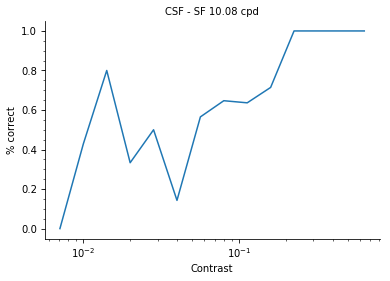

In [205]:
dInd = 8;
plt.semilogx(1e-2*conVals[dInd], np.divide(corrVals[dInd], nTrVals[dInd]));
plt.xlabel('Contrast');
plt.ylabel('% correct')
plt.title('CSF - SF ' + str(sfList[dInd]) + ' cpd');

Now, let's find the contrast reversals

In [229]:
throwFirstN = 2; # throw away the first N contrast reversals
thresh = np.zeros((len(dataMat), 1))
threshAlt = np.zeros((len(dataMat), 1))
for ds in range(len(dataMat)):
    revCons = dataMat[ds][revIdVals[ds][throwFirstN:], conIdx];
    thresh[ds] = hlp.geo_mean(revCons)
    threshAlt[ds] = np.mean(revCons);

### Plot the CSF

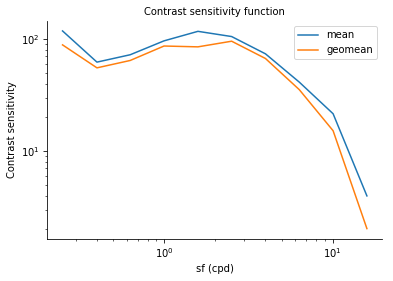

In [235]:
plt.loglog(sfList, 1/(1e-2*thresh));
plt.loglog(sfList, 1/(1e-2*threshAlt));
plt.title('Contrast sensitivity function');
plt.xlabel('sf (cpd)');
plt.ylabel('Contrast sensitivity');
plt.legend(['mean', 'geomean']);